In [16]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/SANIA


In [17]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np
import numba

import matplotlib.pyplot as plt

from experiments import utils
from experiments.loss_functions import LogisticRegressionLoss, BaseOracle
from experiments.methods import *

import scipy
# import optuna
import neptune 

import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [21]:
dataset_name = "colon-cancer"
train_data, train_target, test_data, test_target = utils.get_libsvm(name=dataset_name, test_split=0.2)

scale = 4    
scaling_vec = utils.generate_scaling_vec(size=train_data.shape[1], scale=scale)
if scipy.sparse.issparse(train_data):
    scaled_train_data = train_data.multiply(scaling_vec).tocsr()
    scaled_test_data = test_data.multiply(scaling_vec).tocsr()
else:
    scaled_train_data = scaling_vec * train_data
    scaled_test_data = scaling_vec * test_data

train_dataset = train_data, train_target
test_dataset =  test_data, test_target

scaled_train_dataset = scaled_train_data, train_target
scaled_test_dataset = scaled_test_data, test_target

print(train_data.shape, test_data.shape)
print("Sparsity: ", 1 - (train_data.count_nonzero() / (train_data.shape[0] * train_data.shape[1])))

/home/farshed.abdukhakimov/datasets/libsvm/colon-cancer
(62, 2000) (62, 2000)
Sparsity:  0.0


In [19]:
def train_loop(seed: int, train_dataset: list, test_dataset: list, batch_size: int, n_epochs: int,
               optimizer: BaseOptimizer, lmd: float, **optimizer_kwargs) -> dict: 
    
    np.random.seed(seed)
    
    train_data, train_target = train_dataset
    test_data, test_target = test_dataset
    
    # parameters
    params = np.zeros(train_data.shape[1])
    optim = optimizer(params=params, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=lmd)
    
    # e.g. some libsvm datasets have labels {0.0, 1.0} that cannot be used for logistic regression loss function 
    # hence they will be remapped to {-1.0, 1.0}
    if isinstance(loss_function, LogisticRegressionLoss):
        if not np.array_equal(np.unique(train_target), (-1.0, 1.0)):
            train_target = utils.map_classes_to(train_target, (-1.0, 1.0))
            test_target = utils.map_classes_to(test_target, (-1.0, 1.0))
    
    assert np.array_equal(np.unique(train_target), (-1.0, 1.0))
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    for epoch in range(n_epochs):
        
        # Testing 
        test_loss, test_grad, test_acc = loss_function.func_grad_acc(params, test_data, test_target)
        test_g_norm = np.linalg.norm(test_grad)**2
        history["test/loss"].append(test_loss)
        history["test/acc"].append(test_acc)
        history["test/grad_norm"].append(test_g_norm)
        

        # Training 
        np.random.shuffle(indices)

        train_epoch_loss = 0.0
        train_epoch_acc = 0.0
        train_epoch_grad_norm = 0.0
        
        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss, train_grad, train_acc = loss_function.func_grad_acc(params, batch_data, batch_target)
            
            g_norm = np.linalg.norm(train_grad)**2
            
            optim.step(loss=train_loss, grad=train_grad)

            train_epoch_loss += train_loss
            train_epoch_acc += train_acc
            train_epoch_grad_norm += g_norm
            
            history["train/batch/loss"].append(train_loss)
            history["train/batch/acc"].append(train_acc)
            history["train/batch/grad_norm"].append(g_norm)
            
            
        train_epoch_loss = train_epoch_loss / (idx + 1)
        train_epoch_acc = train_epoch_acc / (idx + 1)
        train_epoch_grad_norm = train_epoch_grad_norm / (idx + 1)
        
        history["train/epoch/loss"].append(train_epoch_loss)
        history["train/epoch/acc"].append(train_epoch_acc)
        history["train/epoch/grad_norm"].append(train_epoch_grad_norm)

        
        # print(f"Epoch [{epoch}/{n_epochs}] | Train Loss: {epoch_loss} | Val Loss: {val_loss}")
        # print(f"Val GradNorm**2: {val_g_norm} | Train GradNorm**2: {epoch_grad_norm}")
        # print(f"Val Acc: {val_acc} | Train Acc: {epoch_acc}\n")
        
        
    # Testing 
    test_loss, test_grad, test_acc = loss_function.func_grad_acc(params, test_data, test_target)
    test_g_norm = np.linalg.norm(test_grad)**2
    history["test/loss"].append(test_loss)
    history["test/acc"].append(test_acc)
    history["test/grad_norm"].append(test_g_norm)
    
    history["params"].append(params)
    
    # print(f"Test Loss: {test_loss} | Test Acc: {test_acc} | Test GradNorm**2: {test_g_norm}")
    
    return history

In [20]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, prefix="val", suptitle=None, 
            threshold=1e-10, max_iters=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
        
    if max_iters is None:
        max_iters = np.max([len(x[f"{prefix}/loss"]) for x in histories])
    
    for history, label, c, ls, lw, m in zip(histories, labels, colors, linestyles, linewidths, markers):
        f_suboptim = history[f"{prefix}/loss"]
        # f_suboptim[f_suboptim < threshold] = 0.0
        
        markevery = [x + np.random.randint(0, 3) for x in range(0, len(history[f"{prefix}/loss"]), len(history[f"{prefix}/loss"]) // 10)]
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)
        ax[1].plot(history[f"{prefix}/acc"], linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m)

    ax[0].set_ylabel(r"$f(w_i)$")
    ax[1].set_ylabel("Accuracy")
        
    # ax[1].set_ylim(bottom=0.75)
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")

    fig.legend()
    ax[0].grid()
    ax[1].grid()
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        fig.savefig(filename)
    else:
        fig.show() 

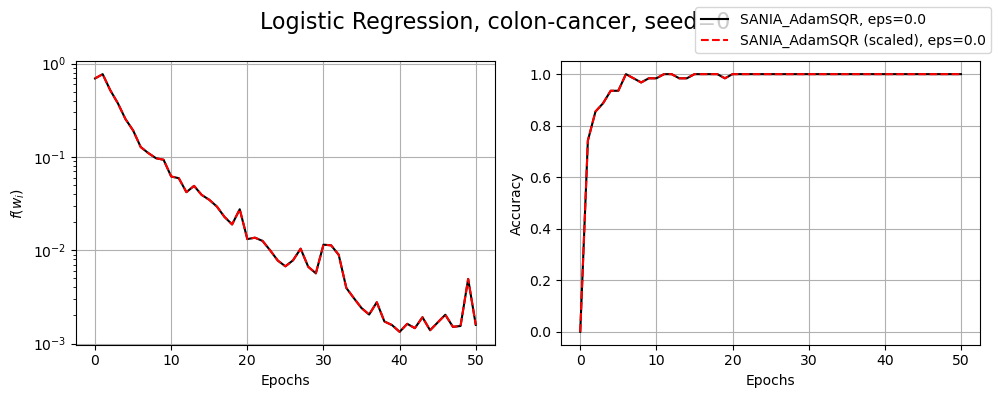

In [23]:
n_epochs = 50

batch_size = 16
seed = 0
lmd = 0.0

# for seed in range(5):

histories = []
labels = []

optimizer = SANIA_AdamSQR
eps = 0.0
hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer,
                lmd=lmd, eps=eps)
histories.append(hist)
labels.append(f"{optimizer.__name__}, {eps=}")

optimizer = SANIA_AdamSQR
eps = 0.0
hist = train_loop(seed=seed, train_dataset=scaled_train_dataset, test_dataset=scaled_test_dataset, 
                batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer, 
                lmd=lmd, eps=eps)
histories.append(hist)
labels.append(f"{optimizer.__name__} (scaled), {eps=}")

plotter(histories=histories, 
    labels=labels,
    colors=["black", "red", "blue", "purple", "teal", "lime"],
    linestyles=["-", "--", "-", "--", "-", "--"],
    prefix="test",
    suptitle=f"Logistic Regression, {dataset_name}, seed={seed}",
    )

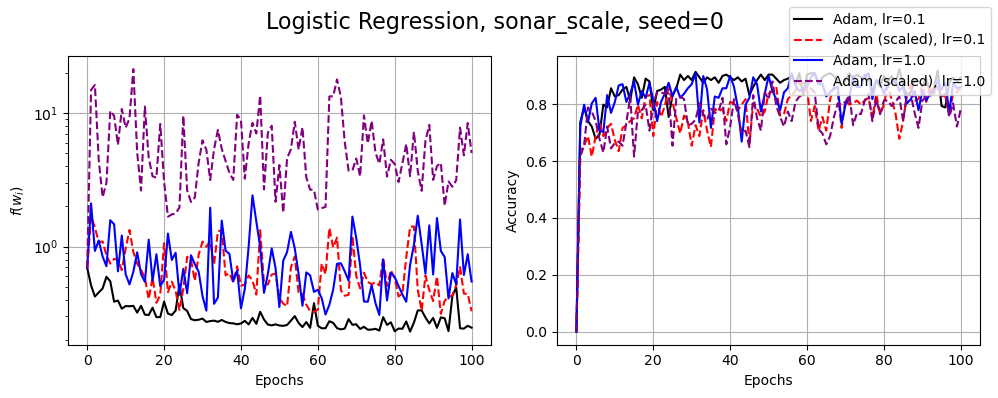

In [56]:
seed = 0
n_epochs = 100

histories = []
labels = []

for lr in  [0.1, 1.0]:

    optimizer = Adam
    hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                    batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer,
                    lmd=lmd, lr=lr)
    histories.append(hist)
    labels.append(f"{optimizer.__name__}, {lr=}")

    hist = train_loop(seed=seed, train_dataset=scaled_train_dataset, test_dataset=scaled_test_dataset, 
                    batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer, 
                    lmd=lmd, lr=lr)
    histories.append(hist)
    labels.append(f"{optimizer.__name__} (scaled), {lr=}")

plotter(histories=histories, 
    labels=labels,
    colors=["black", "red", "blue", "purple", "teal", "lime"],
    linestyles=["-", "--", "-", "--", "-", "--"],
    prefix="test",
    suptitle=f"Logistic Regression, {dataset_name}, seed={seed}",
    )

In [ ]:
def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)

def ttv(tuple_in):
    return torch.cat([t.view(-1) for t in tuple_in])

def flat_hessian(flat_grads,params):
    full_hessian = []
    for i in range(flat_grads.size()[0]):
        temp_hess = torch.autograd.grad(flat_grads[i], params, retain_graph=True)
        full_hessian.append(ttv(temp_hess))
    return torch.stack(full_hessian)

def run_psps2(train_data, train_target, train_dataloader, epochs, precond_method="cg", **kwargs):

    torch.manual_seed(0)
    np.random.seed(0)
    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    # save loss and grad size to history
    hist = []

    optimizer = torch.optim.SGD([w],lr=1)
    loss = loss_function(w, train_data.to(device), train_target.to(device))

    # print("loss",loss)

    g, = torch.autograd.grad(loss, w, create_graph=True)
    hessian = flat_hessian(g,[w])
    f_grad = g.clone().detach()


    # print("grad",torch.norm(g).item())

    if precond_method == "none":
        D = torch.ones_like(w)
    elif precond_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk = diag_estimate_old(w, g, init_iters)
    elif precond_method == "cg" or precond_method == "pcg":
        s = torch.zeros_like(w) # s = H_inv * grad
        r = f_grad - torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
        p = r.detach().clone()
        r_prev = torch.dot(r, r)
        MAX_ITER = train_data.shape[1] * 2
        # MAX_ITER = 1000

    elif precond_method == "scaling_vec":
        scaling_vec = kwargs["scaling_vec"]
        D = (1 / scaling_vec)**2
    elif precond_method == "adam" or precond_method == "adam_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)
        step_t = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif precond_method == "adagrad" or precond_method == "adagrad_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)

    pcg_method = kwargs.get("pcg_method")
    if pcg_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk_pcg = diag_estimate_old(w, g, init_iters)
    elif pcg_method == "adam":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
        step_t_pcg = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif pcg_method == "adagrad":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
        # v_pcg = torch.diag(hessian)
    elif pcg_method == None:
        D_pcg = torch.ones_like(g)

    cg_steps = []

    for epoch in range(epochs):

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]

        print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
        hist.append([loss.item(), grad_norm_sq.item(), acc])

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.detach().clone()

            elif precond_method == "pcg":
                
                if pcg_method == "hess_diag":
                #hess = loss_hessian(w, batch_data, batch_target)
                    D_pcg = 1 / torch.diag(hessian)  
                elif pcg_method == "hutch":
                    vk_pcg = diag_estimate_old(w, g, 1)
                    # Smoothing and Truncation
                    Dk_pcg = beta * Dk_pcg + (1 - beta) * vk_pcg
                    Dk_hat = torch.abs(Dk_pcg)
                    Dk_hat[Dk_hat < alpha] = alpha
                    D_pcg = 1 / Dk_hat
                elif pcg_method == "adam":
                    step_t_pcg += 1
                    v_pcg = betas[1] * v_pcg + (1 - betas[1]) * f_grad.square()
                    v_hat = v_pcg / (1 - torch.pow(betas[1], step_t_pcg))
                    D_pcg = 1 / v_hat
                    #D_pcg = 1 / (torch.sqrt(v_hat) + 1e-8)
                elif pcg_method == "adagrad":
                    v_pcg.add_(f_grad.square())
                    #print(v_pcg)
                    # D_pcg = 1/v_pcg
                    # print(torch.norm(v_pcg),"v_pcg")
                    D_pcg = v_pcg
                    eps = 1e-3

                    D_pcg[torch.abs(v_pcg) > eps] = 1 / (v_pcg[torch.abs(v_pcg) > eps])# + 1e-8)

                    # print(torch.norm(D_pcg),"D_pcg")


                    #print(D_pcg)
                elif pcg_method == "none":
                    D_pcg = torch.ones_like(f_grad)

                #hess = loss_hessian(w, batch_data, batch_target)
                
        
                #hess_diag_inv = 1 / torch.diag(hess)

                hess_diag_inv = D_pcg.clone()


                # hess_diag_inv *= 0
                # hess_diag_inv +=1

                # hess_diag=1/hess_diag_inv
                gamma=0.7
            

                # Preconditioned CG is here
                s = torch.zeros_like(w) # s = H_inv * grad
                x = torch.zeros_like(w)
                r = f_grad.clone()
                z = hess_diag_inv * r
                p = z.clone()
                # step_size = 1.0

                for cg_step in range(MAX_ITER):
                    hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                
                    if torch.dot(p,hvp)<=0:
                        # if cg_step==0:
                            
                        # print("NEGATIVE CURVATURE")
                        s=gamma*x  +(1-gamma)*p*torch.sign(torch.dot(p,f_grad))
                        hvs = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
                        # print("step_size=",torch.dot(s,hvs))
                        # print(torch.max(torch.tensor([loss/torch.dot(s,hvs),0])))
                        # step_size=torch.min(torch.max(torch.tensor([loss/torch.dot(s,hvs),0])),torch.tensor(20))
                        step_size=torch.min(torch.tensor([torch.abs(loss/torch.dot(s,hvs)),5]))
                        #step_size=1.0
                        # print(step_size)
                        # print("Nega:stepsize",step_size)
                        # print(f"PCG Took {cg_step}")
                        break
                    alpha_k = torch.dot(r, z) / torch.dot(p, hvp)
                    # print("alpha",alpha_k)
                    x = x + alpha_k * p
                    # print("x",x*scaling)
                    r_prev = r.clone()
                    r = r - alpha_k * hvp
                    # print(torch.dot(r,hess_diag_inv*r))
                    # if torch.norm(r)<1e-4:
                    # print(torch.dot(r,hess_diag_inv*r),'sssss')
                    if torch.dot(r,hess_diag_inv*r) < 1e-5:
                        s=x
                        # print("hit stopping")
                        # print(f"PCG Took {cg_step}")
                        # Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
                        # diff = torch.norm(Ax - f_grad)
                        # print(f"PCG Took {cg_step} to reach diff={diff}")
                        # cg_steps.append(cg_step)
                        grad_norm_sq_scaled = torch.dot(f_grad, s)
                        if 2 * loss <= grad_norm_sq_scaled:
                            c = loss / ( grad_norm_sq_scaled )
                            det = 1 - 2 * c
                            if det < 0.0:
                                step_size = 1.0 
                            else:
                                # print("**")
                                step_size = 1 - torch.sqrt(det)
                        else:
                            # print(f"[{epoch}, {i}] No solution")
                            # print("***")
                            step_size = 1.0
                        # print("sp:stepsize",step_size)
                        
                        break

                    z_prev = z.clone()
                    z = hess_diag_inv * r
                    beta_k = torch.dot(r, z) / torch.dot(r_prev, z_prev)
                    p = z + beta_k * p



            with torch.no_grad():
                w.sub_(step_size *s)


    return hist

# hist_pcg = run_psps2(train_data, train_target, train_dataloader, EPOCHS, precond_method="pcg",pcg_method="adagrad")

In [ ]:
class SANIA_PCG(BaseOptimizer):
    def __init__(self, params: np.ndarray, 
                 lr: float = 1.0):
        self.params = params
        self.lr = lr 
        
        self.defaults = dict(lr=lr)
        
    def step(self, loss: np.ndarray, grad: np.ndarray, preconditioner: np.ndarray):
        
        s = grad / preconditioner
        
        # Scaled norm of gradients ||g||_{inv(B_t)}
        grad_norm = np.dot(grad, s)

        # Polyak step size
        step_size = 1.0 
        if 2 * loss.item() <= grad_norm:
            c = loss.item() / ( grad_norm )
            det = 1 - 2 * c
            if det > 0.0:
                step_size = 1 - np.sqrt(det)
        
        self.params -= self.lr * step_size * s
        
        return loss, grad